In [1]:
from IPython.display import display, HTML,clear_output
# css = """
# .output {
# flex-direction: row;
# flex-wrap: wrap;
# }
# """

# HTML('<style>{}</style>'.format(css))

In [2]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [3]:
# %pip install --no-cache-dir matplotlib

# from pandasql import sqldf
import requests
import brotli
from datetime import datetime
import time
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json

In [4]:
pd.options.mode.copy_on_write = True

In [5]:
origin_url="https://www.nseindia.com/market-data/most-active-contracts"
url = 'https://www.nseindia.com/api/snapshot-derivatives-equity?index=contracts'
f_url = 'https://www.nseindia.com/api/quote-derivative?symbol=NIFTY&identifier=FUTIDXNIFTY26-06-2025XX0.00'
default_header = {
    "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/129.0.0.0 Safari/537.36"
}

header = {
             "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/130.0.0.0 Safari/537.36",
             "Accept-Language": "en-US,en;q=0.9,hi;q=0.8"
            }


session = requests.session()
nse_live = session.get(origin_url, headers=default_header)
cookies = nse_live.cookies
session.get(url, headers=header, cookies=cookies)


<Response [200]>

In [6]:
def index_data(f_data):
    f_df = [item for item in f_data if item.get("metadata", {}).get("optionType") == '-']
    met_df = pd.DataFrame(f_df)
    df = pd.concat([met_df.drop(columns=['metadata','marketDeptOrderBook']),met_df["metadata"].apply(pd.Series),met_df["marketDeptOrderBook"].apply(pd.Series)],axis=1)
    c_df = pd.concat([df['expiryDate'],df['bid'].apply(pd.Series),df['ask'].apply(pd.Series)],axis=1)
    df = pd.concat([df.drop(columns=['carryOfCost','tradeInfo','otherInfo','bid','ask']),df['carryOfCost'].apply(pd.Series),df['tradeInfo'].apply(pd.Series)],axis=1)
    df = pd.concat([df.drop(columns='price'),df['price'].apply(pd.Series)],axis=1)
    df = df.drop(columns=['instrumentType','optionType','identifier','openPrice','highPrice','lowPrice','closePrice',
                    'prevClose','change','pChange','numberOfContractsTraded','totalTurnover','instrumentType','carry','lastPrice','marketLot','premiumTurnover'])
    return df,c_df

In [7]:
chain_origin_url="https://www.nseindia.com/option-chain"
ni_default_header = {
    "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/129.0.0.0 Safari/537.36"
}
nifty_url ='https://www.nseindia.com/api/option-chain-indices?symbol=NIFTY'
nifty_url='https://www.nseindia.com/api/option-chain-v3?type=Indices&symbol=NIFTY&expiry=19-Jun-2025'
ni_header = {
    "Connection": "keep-alive",
    "Cache-Control": "max-age=0",
    "DNT": "1",
    "Upgrade-Insecure-Requests": "1",
    "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) "
                  "Chrome/111.0.0.0 Safari/537.36",
    "Sec-Fetch-User": "?1", "Accept": "*/*", "Sec-Fetch-Site": "none", "Sec-Fetch-Mode": "navigate",
    "Accept-Encoding": "gzip, deflate, br", "Accept-Language": "en-US,en;q=0.9,hi;q=0.8"
    }
ni_session = requests.Session()
ni_nse_live = session.get(chain_origin_url, headers=ni_default_header)
ni_cookies = ni_nse_live.cookies
# nse_live = session.get("http://nseindia.com", headers=ni_header)
ni_session.get(nifty_url, headers=ni_header,cookies=ni_cookies)

<Response [200]>

In [8]:
columns = [
    "underlying", "expiryDate", "optionType", "strikePrice", "lastPrice", "numberOfContractsTraded",
    "totalTurnover", "openInterest", "underlyingValue", "pChange", "timestamp"
]
# Create an empty DataFrame
filter_df = pd.DataFrame(columns=columns)

In [9]:
def dataframe(df):
    data = []
    for i in range(0,len(df)):
        calloi=callcoi=cltp=putoi=putcoi=pltp=0
        ctotaltradevaluem=ctotalBellq=ctotalSellq=ptotaltradevaluem=ptotalBellq=ptotalSellq=0
        pbidQty=pbidprice=paskQty=paskPrice=cbidQty=cbidprice=caskQty=caskPrice=CALL_iv=PUT_iv = 0
        stp = df['strikePrice'][i]
        if(df['CE'][i]==0):
            calloi = callcoi =0
        else:
            calloi = float(df['CE'][i]['openInterest'])
            callcoi = float(df['CE'][i]['changeinOpenInterest'])
            ctotalBellq = float(df['CE'][i]['totalBuyQuantity'])
            ctotalSellq = float(df['CE'][i]['totalSellQuantity'])
            # CE_BP1 = float(df['CE'][i]['buyPrice1'])
            # CE_Bq1 = float(df['CE'][i]['buyQuantity1'])
            # CE_SP1 = float(df['CE'][i]['sellPrice1'])
            # CE_Sq1 = float(df['CE'][i]['sellQuantity1'])
            cstp = float(df['CE'][i]['underlyingValue'])
        if(df['PE'][i]==0):
            putoi = putcoi = 0
        else:
            putoi = float(df['PE'][i]['openInterest'])
            putcoi = float(df['PE'][i]['changeinOpenInterest'])
            ptotalBellq = float(df['PE'][i]['totalBuyQuantity'])
            ptotalSellq = float(df['PE'][i]['totalSellQuantity'])
            # PE_BP1 = float(df['PE'][i]['buyPrice1'])
            # PE_Bq1 = float(df['PE'][i]['buyQuantity1'])
            # PE_SP1 = float(df['PE'][i]['sellPrice1'])
            # PE_Sq1 = float(df['PE'][i]['sellQuantity1'])


        opdata = {
            'CALL_OI' : calloi,'CALL_CHNG_OI':callcoi,
            # 'CE_BP1':CE_BP1,'CE_Bq1':CE_Bq1,'CE_SP1':CE_SP1,'CE_Sq1':CE_Sq1,
            'CALL_BQ':ctotalBellq,'CALL_SA':ctotalSellq,'strikePrice':stp,
            'PUT_SA':ptotalSellq,'PUT_BQ':ptotalBellq,'PUT_CHNG_OI':putcoi,'PUT_OI' : putoi,
            # 'PE_BP1':PE_BP1,'PE_Bq1':PE_Bq1,'PE_SP1':PE_SP1,'PE_Sq1':PE_Sq1,
            'current_stp':cstp}
        data.append(opdata)
    optionchain = pd.DataFrame(data)
    optionchain['%_SQ'] = ((optionchain['CALL_SA'] - optionchain['PUT_SA']) / ((optionchain['CALL_SA'] + optionchain['PUT_SA']) / 2)) * 100
    optionchain['%_BQ'] = ((optionchain['CALL_BQ'] - optionchain['PUT_BQ']) / ((optionchain['CALL_BQ'] + optionchain['PUT_BQ']) / 2)) * 100
    #optionchain =optionchain.append(optionchain[['CALL_OI','CALL_CHNG_OI','PUT_OI','PUT_CHNG_OI','CALL_TTV','PUT_TTV','CALL_BQ','PUT_BQ','CALL_SA','PUT_SA']].sum(),ignore_index=True).fillna(0)
    return optionchain


In [10]:
def plot(df):
    df = df.drop_duplicates().tail(20)
    df['timestamp'] = pd.to_datetime(df['timestamp'])  # Ensure timestamp is datetime

    fig, ax = plt.subplots(figsize=(10,6))

    # Group by expiryDate and plot each group
    for key, grp in df.groupby(['expiryDate']):
        ax.plot(grp['timestamp'], grp['lastPrice'], linestyle='-', marker='o', label=f'Last Price ({key})')
        ax.plot(grp['timestamp'], grp['underlyingValue'], linestyle='--', marker='x', label=f'Underlying Value ({key})')

    # Adding labels and title
    ax.set_xlabel('Timestamp')
    ax.set_ylabel('Value')
    ax.set_title('Last Price and Underlying Value over Time by Expiry Date')

    # Adding legend
    ax.legend(loc='best', fontsize='small')

    # Adding grid and rotating x-axis labels
    ax.grid(True)
    plt.xticks(rotation=45)

    plt.tight_layout()

    # Save the plot as an image file
    plt.savefig('line_graph.png')

    # Show the plot
    plt.show()


In [11]:
def process_nifty_options(df, option_df):
    """
    Processes NIFTY options data by performing a left join with API data, 
    filtering relevant columns, and renaming option-specific columns.

    Parameters:
    df (pd.DataFrame): The main dataframe containing options data.
    ni_session (requests.Session): Session object for API requests.
    nifty_url (str): URL to fetch NIFTY option data.
    ni_header (dict): Headers for API request.

    Returns:
    pd.DataFrame: Processed dataframe with relevant columns.
    """

    # Filter for NIFTY and sort data
    df = df[df['underlying'] == 'NIFTY'].sort_values(by=['strikePrice', 'openInterest'], ascending=True)

    # Perform a left join
    join_df = df.merge(option_df, on="strikePrice", how="left")

    # Define common columns
    common_cols = [
        "expiryDate", "optionType", "strikePrice", "lastPrice", 
        "numberOfContractsTraded", "totalTurnover", "openInterest", 
        "underlyingValue", "pChange", "current_stp"
    ]

    # Conditional selection of call/put columns
    call_cols = ["CALL_OI", "CALL_CHNG_OI", "CALL_BQ", "CALL_SA"]
    put_cols = ["PUT_OI", "PUT_CHNG_OI", "PUT_BQ" ,"PUT_SA" ]

    # Rename mapping
    rename_mapping = {
        "CALL_OI": "oi", "CALL_CHNG_OI": "coi", "CALL_BQ": "buy_q", "CALL_SA": "sell_q",
        "PUT_OI": "oi", "PUT_CHNG_OI": "coi", "PUT_BQ": "buy_q", "PUT_SA": "sell_q"
    }

    # Create new columns based on 'optionType'
    for call_col, put_col in zip(call_cols, put_cols):
        join_df[rename_mapping[call_col]] = np.where(
            join_df["optionType"].str.lower() == "call", join_df[call_col], join_df[put_col]
        )

    # Keep only relevant columns
    final_cols = common_cols + ["oi", "coi", "buy_q", "sell_q"]
    join_df = join_df[final_cols]
    join_df.drop(columns =['totalTurnover'],inplace=True)
    return join_df

,expiryDate,optionType,strikePrice,lastPrice,numberOfContractsTraded,openInterest,underlyingValue,pChange,current_stp,oi,coi,buy_q,sell_q
0,31-Jul-2025,-,0,25022.90,3537,83739,24857.65,0.150088,NaN,NaN,NaN,NaN,NaN
1,26-Jun-2025,-,0,24900.40,27853,154921,24857.65,0.127067,NaN,NaN,NaN,NaN,NaN
2,19-Jun-2025,Call,24800,130.00,935739,64885,24857.65,1.721440,24875.2,67053.0,24622.0,854475.0,673425.0
3,19-Jun-2025,Put,24800,57.10,1323070,174148,24857.65,-38.236885,24875.2,168693.0,85765.0,3465900.0,2164950.0
4,19-Jun-2025,Call,24850,99.00,941560,66070,24857.65,-0.352290,24875.2,70251.0,22329.0,3836325.0,687900.0
5,19-Jun-2025,Put,24850,75.60,954633,100982,24857.65,-33.362715,24875.2,98998.0,53883.0,3474300.0,1150950.0
6,19-Jun-2025,Put,24900,100.35,1606891,147263,24857.65,-27.987083,24875.2,141030.0,87751.0,3818700.0,1271100.0
7,19-Jun-2025,Call,24900,72.50,2056170,165343,24857.65,-4.100529,24875.2,170465.0,78188.0,4456050.0,2194800.0
8,19-Jun-2025,Put,24950,129.40,617066,40900,24857.65,-23.927102,24875.2,37362.0,25718.0,611325.0,345075.0
9,19-Jun-2025,Call,24950,52.00,1294340,88618,24857.65,-7.964602,24875.2,90840.0,43353.0,3827475.0,1321125.0


,underlyingValue,volumeFreezeQuantity,expiryDate,strikePrice,totalBuyQuantity,totalSellQuantity,tradedVolume,value,vmap,openInterest,changeinOpenInterest,pchangeinOpenInterest,bestBuy,bestSell
0,24879.40,1801,26-Jun-2025,0,484200,376725,28405.0,530988.30,24924.64,154877.0,636.0,0.412342,24905.0,24907.6
1,24856.65,1801,31-Jul-2025,0,127500,142050,3596.0,67548.85,25045.92,83739.0,182.0,0.217815,25016.1,25023.4
2,24879.40,1801,28-Aug-2025,0,42225,41925,618.0,11657.42,25150.85,7922.0,123.0,1.577125,25128.0,25129.4


,expiryDate,0,1,2,3,4,0,1,2,3,4
0,26-Jun-2025,"{'price': 24905, 'quantity': 75}","{'price': 24900.6, 'quantity': 525}","{'price': 24900.5, 'quantity': 525}","{'price': 24900.4, 'quantity': 225}","{'price': 24900.3, 'quantity': 300}","{'price': 24907.6, 'quantity': 300}","{'price': 24907.7, 'quantity': 300}","{'price': 24907.8, 'quantity': 375}","{'price': 24907.9, 'quantity': 75}","{'price': 24908, 'quantity': 75}"
1,31-Jul-2025,"{'price': 25016.1, 'quantity': 225}","{'price': 25016, 'quantity': 600}","{'price': 25015.9, 'quantity': 300}","{'price': 25015.7, 'quantity': 900}","{'price': 25015.6, 'quantity': 825}","{'price': 25023.4, 'quantity': 75}","{'price': 25023.9, 'quantity': 300}","{'price': 25024, 'quantity': 75}","{'price': 25024.3, 'quantity': 300}","{'price': 25024.4, 'quantity': 150}"
2,28-Aug-2025,"{'price': 25128, 'quantity': 450}","{'price': 25125, 'quantity': 150}","{'price': 25123, 'quantity': 150}","{'price': 25122.9, 'quantity': 75}","{'price': 25122.7, 'quantity': 150}","{'price': 25129.4, 'quantity': 150}","{'price': 25130.3, 'quantity': 75}","{'price': 25130.6, 'quantity': 75}","{'price': 25130.7, 'quantity': 375}","{'price': 25130.8, 'quantity': 75}"


,CALL_OI,CALL_CHNG_OI,CALL_BQ,CALL_SA,strikePrice,PUT_SA,PUT_BQ,PUT_CHNG_OI,PUT_OI,current_stp,%_SQ,%_BQ
37,7190.0,571.0,174300.0,55425.0,24650,740850.0,3459825.0,20474.0,48808.0,24875.2,-172.157860,-180.815189
38,27149.0,5440.0,433575.0,209100.0,24700,1477650.0,4308375.0,54603.0,130600.0,24875.2,-150.413517,-163.426438
39,16912.0,8519.0,336300.0,163200.0,24750,813375.0,3581775.0,36778.0,61391.0,24875.2,-133.154136,-165.666813
40,67053.0,24622.0,854475.0,673425.0,24800,2164950.0,3465900.0,85765.0,168693.0,24875.2,-105.097107,-120.888812
41,70251.0,22329.0,3836325.0,687900.0,24850,1150950.0,3474300.0,53883.0,98998.0,24875.2,-50.362999,9.904078
42,170465.0,78188.0,4456050.0,2194800.0,24900,1271100.0,3818700.0,87751.0,141030.0,24875.2,53.302173,15.404695
43,90840.0,43353.0,3827475.0,1321125.0,24950,345075.0,611325.0,25718.0,37362.0,24875.2,117.158804,144.910787
44,181104.0,54792.0,4667025.0,2596875.0,25000,466650.0,693075.0,19432.0,52885.0,24875.2,139.070189,148.278950
45,58295.0,27240.0,3771525.0,843075.0,25050,82125.0,306600.0,2901.0,9496.0,24875.2,164.494163,169.927356
46,130140.0,46906.0,4150800.0,1576875.0,25100,141075.0,349200.0,4301.0,16640.0,24875.2,167.152711,168.960000


,underlying,expiryDate,optionType,strikePrice,lastPrice,numberOfContractsTraded,totalTurnover,openInterest,underlyingValue,pChange
1,BANKNIFTY,26-Jun-2025,-,0,55989.00,11002,187258.800339,63294,55811.50,0.373247
2,BSE,26-Jun-2025,-,0,2630.00,16736,166390.693650,29431,2619.90,-1.424288
4,HINDZINC,26-Jun-2025,-,0,460.65,24034,136218.464585,20871,459.10,-5.313464
8,INDUSINDBK,26-Jun-2025,-,0,846.35,18822,80732.387250,79232,846.50,4.726845
16,HDFCBANK,26-Jun-2025,-,0,1934.30,4996,54527.905960,173570,1927.50,0.031029
17,VEDL,26-Jun-2025,-,0,453.00,9879,52245.653220,66508,456.05,-0.483304
18,INFY,26-Jun-2025,-,0,1627.80,7592,50231.103440,130885,1627.70,-0.671223
19,HINDZINC,31-Jul-2025,-,0,463.20,7965,45328.052700,6838,459.10,-5.295441


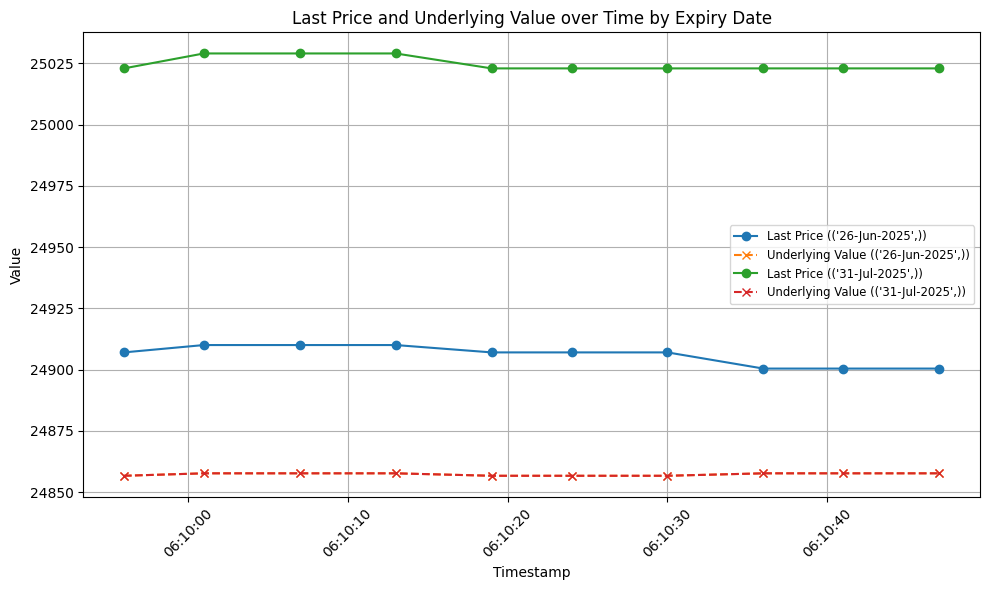

In [ ]:
def main_dis_run(filter_df):
  try:
    while True:
      clear_output(wait=True)
      data = session.get(url,headers=header).json()['value']['data']
      df = pd.DataFrame(data)
      df.drop(columns =['identifier','instrumentType','instrument','premiumTurnover'],inplace=True)
      f_data = session.get(f_url,headers=header).json()['stocks']
      c_df = index_data(f_data=f_data)
      try:
        ni_data = ni_session.get(nifty_url, headers=ni_header, cookies=ni_cookies).json()['filtered']['data']
        df1 = pd.DataFrame(ni_data).fillna(0)
        df1 = pd.DataFrame(ni_data).fillna(0)
        option_df = dataframe(df1)
        price = int(option_df['current_stp'][0])
        display(process_nifty_options(df, option_df))
        # display(f_df[f_df['underlying'] == 'NIFTY'].sort_values(by=['strikePrice', 'openInterest'], ascending=True))
        display(c_df[0],c_df[1])
        range_price = list(range(round(price/100)*100-250,round(price/100)*100+250,50))
        display(option_df[(option_df.strikePrice.isin(range_price))])
      except Exception as e:
        print(f'issue with option chain')
        # raise e
        dis_df = df[df['underlying'] == 'NIFTY'].sort_values(by=['strikePrice', 'openInterest'], ascending=True)
        dis_df.drop(columns =['totalTurnover'],inplace=True)
        display(dis_df)
        display(c_df[0],c_df[1])
      
      filtered_df = df[(df['underlying'] == 'NIFTY') & (df['optionType'] == '-')] 
      filtered_df['timestamp'] = datetime.now().strftime('%Y-%m-%d %H:%M:%S') 
      date = datetime.now().strftime('%Y-%m-%d')
      # csv_file_path = f'D:/badri/OptionChainData/nifty/{date}.csv'
      csv_file_path = f'C:/Users/2199222/OneDrive - Cognizant/Desktop/optiondata/nifty/{date}.csv'
      # filtered_df.to_csv(csv_file_path, mode='a', header=False, index=False)
      filter_df = pd.concat([filter_df, filtered_df], ignore_index=True)
      # df[df['underlying'] == 'NIFTY'].sort_values(by=['strikePrice','openInterest'],ascending=True).to_csv('D:/badri/OptionChainData/nifty/nifty.csv',index=False)
      display(df[df['underlying'] != 'NIFTY'])
      # display(filter_df)
      plot(filter_df)
      time.sleep(5)
  except Exception as e:
      clear_output(wait=True)
      print(f'trying to retry to re-slove issue')
      # raise e
      main_dis_run(filter_df)

main_dis_run(filter_df)

In [ ]:
# df = pd.read_csv('D:/badri/OptionChainData/nifty/nifty.csv')
# df_unique = df.drop_duplicates(subset=df.columns.difference(['timestamp']), keep='last')